In [12]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using Random

import ReactiveMP: update!

In [34]:
@model function hgf(real_k, real_w, z_variance, y_variance)
    
    xt_min_mean = datavar(Float64)
    xt_min_var  = datavar(Float64)
    
    zt_min_mean = datavar(Float64)
    zt_min_var  = datavar(Float64)
    
    xt_min ~ NormalMeanVariance(xt_min_mean, xt_min_var)
    zt_min ~ NormalMeanVariance(zt_min_mean, zt_min_var)
    
    zt ~ NormalMeanVariance(zt_min, z_variance) where { q = q(zt_min, zt)q(z_variance) }
    
    gcv_node, xt ~ GCV(xt_min, zt, real_k, real_w) where { q = q(xt, xt_min)q(zt)q(κ)q(ω) }
    
    y = datavar(Float64)
    
    y ~ NormalMeanVariance(xt, y_variance)
    
    return zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var
end

hgf (generic function with 1 method)

In [77]:
function inference(; data, iters, real_k, real_w, z_variance, y_variance)
    n = length(data)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler()
    
    mz = keep(Marginal)
    mx = keep(Marginal)
    fe = ScoreActor(Float64)

    model, (zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var) = hgf(real_k, real_w, z_variance, y_variance)

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), mz)
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), mx)
    s_fe = subscribe!(score(Float64, BetheFreeEnergy(), model, fe_scheduler), fe)
    
    # Initial prior messages
    current_zt_mean = 0.0
    current_zt_var  = 10.0
    
    current_xt_mean = 0.0
    current_xt_var  = 10.0

    # Prior marginals
    setmarginal!(gcv_node, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(gcv_node, :z, NormalMeanVariance(0.0, 5.0))
    
    for i in 1:n
        
        for _ in 1:iters
            update!(y, data[i])
            update!(zt_min_mean, current_zt_mean)
            update!(zt_min_var, current_zt_var)
            update!(xt_min_mean, current_xt_mean)
            update!(xt_min_var, current_xt_var)
            
            release!(fe_scheduler)
        end
        
        release!(fe)
        release!(ms_scheduler)
        
        current_zt_mean, current_zt_var = mean_var(last(mz))::Tuple{Float64, Float64}
        current_xt_mean, current_xt_var = mean_var(last(mx))::Tuple{Float64, Float64}
    end
    
    unsubscribe!((s_mz, s_mx, s_fe))
    
    return map(getvalues, (mz, mx, fe))
end

inference (generic function with 1 method)

In [78]:
n = 300
iters = 10

rng = MersenneTwister(123)

real_k = 1.0
real_w = 0.0

z_prev = 0.0
x_prev = 0.0

z = Vector{Float64}(undef, n)
v = Vector{Float64}(undef, n)
x = Vector{Float64}(undef, n)
y = Vector{Float64}(undef, n)

y_variance = abs2(1.0)
z_variance = abs2(0.5)

for i in 1:n
    z[i] = rand(rng, Normal(z_prev, sqrt(z_variance)))
    v[i] = exp(real_k * z[i] + real_w)
    x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
    y[i] = rand(rng, Normal(x[i], sqrt(y_variance)))
    
    z_prev = z[i]
    x_prev = x[i]
end

In [79]:
using CairoMakie

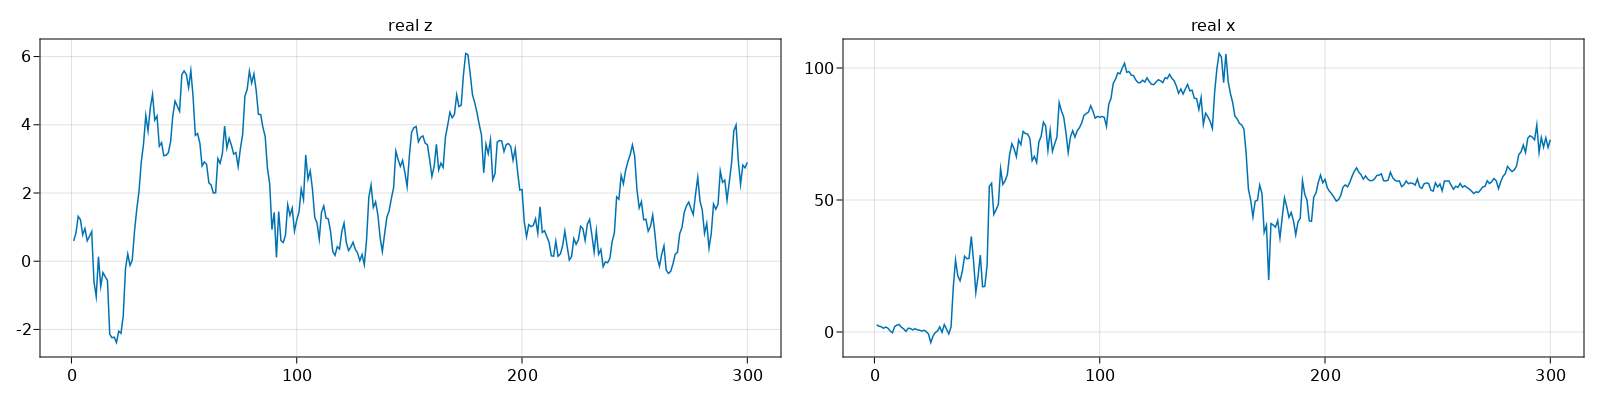

In [80]:
let 
    f = Figure(resolution = (1600, 400))
    
    ax1 = Axis(f[1, 1], title = "real z")
    ax2 = Axis(f[1, 2], title = "real x")
    
    lines!(ax1, 1:n, z)
    lines!(ax2, 1:n, x)
    # scatter!(ax2, 1:n, y)
    
    f
end

In [81]:
mz, mx, fe = inference(;
    data = y, 
    iters = iters, 
    real_k = real_k, 
    real_w = real_w, 
    z_variance = z_variance, 
    y_variance = y_variance
);

last(fe) = 827.3686614820472


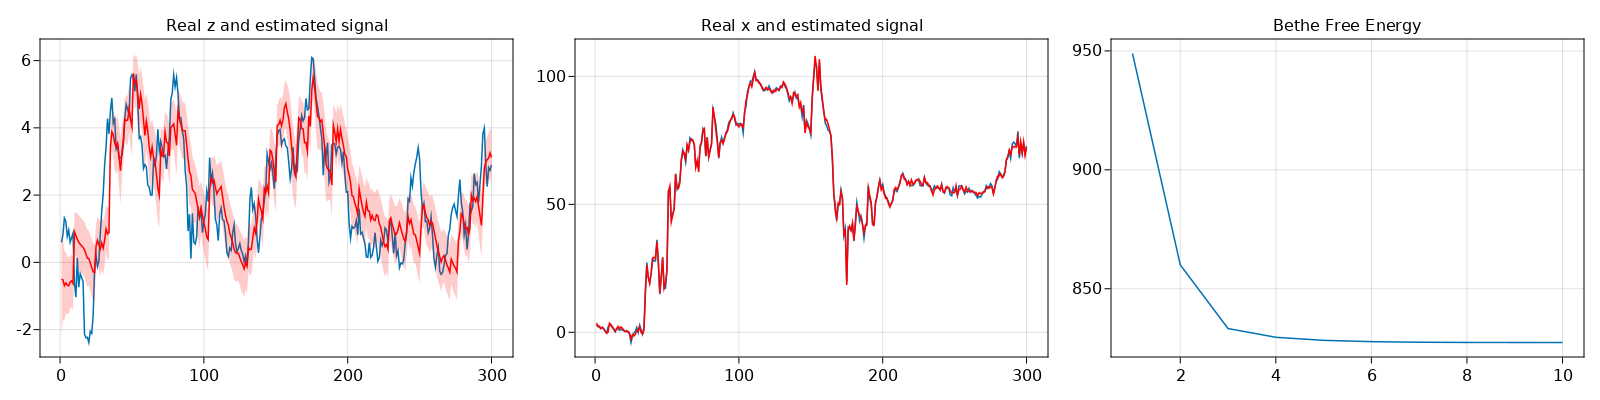

In [82]:
let 
    f = Figure(resolution = (1600, 400))
    
    ax1 = Axis(f[1, 1], title = "Real z and estimated signal")
    ax2 = Axis(f[1, 2], title = "Real x and estimated signal")
    ax3 = Axis(f[1, 3], title = "Bethe Free Energy")
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, mean.(mz), color = :red)
    band!(ax1, 1:n, mean.(mz) .- std.(mz), mean.(mz) .+ std.(mz), color = (:red, 0.2))
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, mean.(mx), color = :red)
    band!(ax2, 1:n, mean.(mx) .- std.(mx), mean.(mx) .+ std.(mx), color = (:red, 0.2))
    # scatter!(ax2, 1:n, y)
    
    @show last(fe)
    
    lines!(ax3, 1:iters, fe)
    
    f
end

In [83]:
@benchmark mz, mx, fe = inference(;
    data = $y, 
    iters = $iters, 
    real_k = $real_k, 
    real_w = $real_w, 
    z_variance = $z_variance, 
    y_variance = $y_variance
)

BenchmarkTools.Trial: 33 samples with 1 evaluation.
 Range (min … max):  131.755 ms … 175.503 ms  ┊ GC (min … max):  0.00% … 11.84%
 Time  (median):     158.449 ms               ┊ GC (median):    12.55%
 Time  (mean ± σ):   155.941 ms ±  13.698 ms  ┊ GC (mean ± σ):   7.16% ±  6.20%

            ▃  ▃                      ▃           █ ▃  ▃  ▃      
  ▇▁▁▇▁▁▁▁▇▁█▇▇█▁▇▁▁▁▇▇▇▁▁▇▁▁▁▁▁▁▁▁▁▁▁█▇▁▁▁▇▇▁▁▁▇▁█▁█▇▇█▇▁█▁▁▁▇ ▁
  132 ms           Histogram: frequency by time          176 ms <

 Memory estimate: 66.15 MiB, allocs estimate: 1065027.

In [84]:
@btime mz, mx, fe = inference(;
    data = $y, 
    iters = $iters, 
    real_k = $real_k, 
    real_w = $real_w, 
    z_variance = $z_variance, 
    y_variance = $y_variance
);

  122.385 ms (1065027 allocations: 66.15 MiB)
